# (13) Figs: NeuroAI Sym

**Motivation**: Make figures for NeuroAI Symposium at WashU (May 15, 2024). Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from analysis.eval import sparse_score
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
# HIDE CODE


def detect_dead_neurons(tr: TrainerVAE):
    dead_thres = {
        'poisson': 0.008,
        'gaussian': 0.08,
        'laplace': 0.08,
    }
    data, loss, etc = tr.validate()

    if tr.model.cfg.type == 'categorical':
        thres = None
        dead = np.zeros(np.prod(tr.model.size))
    else:
        thres = dead_thres.get(tr.model.cfg.type)
        dead = loss['kl_diag'] < thres
    return data, loss, etc, thres, dead.astype(bool)

## Fig save dir

In [3]:
from figures.imgs import plot_weights

fig_dir = pjoin(fig_base_dir, 'washu_may15')
os.makedirs(fig_dir, exist_ok=True)
print(os.listdir(fig_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 600,
}

['phi_lin_laplace.png', 'phi_lin_poisson.png', 'phi_lin_categorical.png', 'phi_lin_gaussian.png']

## Device

In [4]:
device_idx = 0
device = f'cuda:{device_idx}'

model_type = 'poisson'

## Load model, plot dec weights

In [5]:
root = add_home('Dropbox/chkpts/PoissonVAE')

models2load = {
    'poisson': 'poisson-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:46)',
    'categorical': 'categorical-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:04)',
    'gaussian': 'gaussian-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:09)',
    'laplace': 'laplace-<lin|lin>-DOVES-mc_mach-5_(2024_05_14,04:12)',
}
models2load = {k: v.replace('/', ':') for k, v in models2load.items()}

In [6]:
trainers = {}
for name, load_path in models2load.items():
    try:
        trainers[name], _ = load_quick(
            pjoin(root, load_path),
            lite=True,
            device=device,
            verbose=True,
        )
    except FileNotFoundError:
        continue

# params: 262.7 K

# params: 262.7 K

# params: 394.2 K

# params: 394.2 K

poisson, # dead: 8

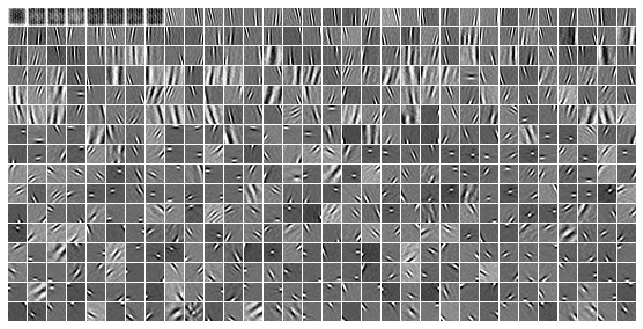

categorical, # dead: 0

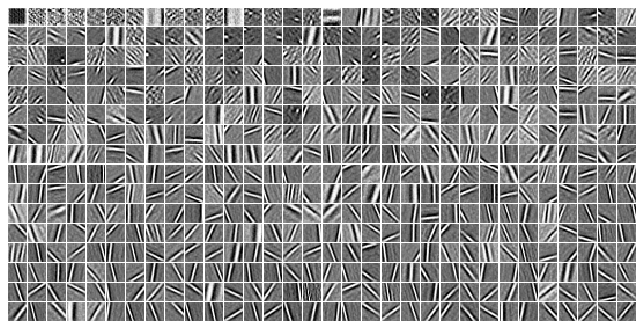

gaussian, # dead: 401

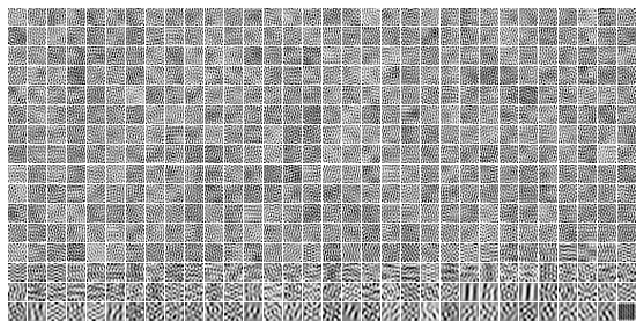

laplace, # dead: 416

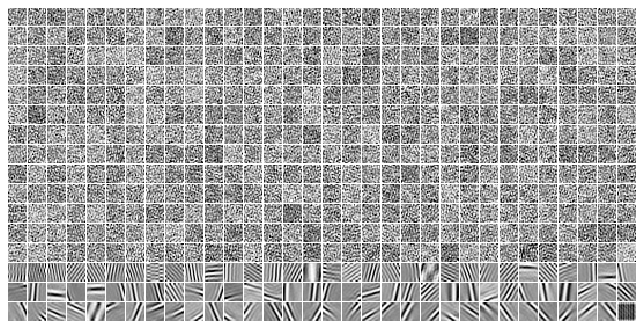

CPU times: user 10.6 s, sys: 1.59 s, total: 12.2 s
Wall time: 6.39 s


In [7]:
%%time

for name, tr in trainers.items():
    data, loss, etc, thres, dead = detect_dead_neurons(tr)
    print(f"{name}, # dead: {dead.sum()}")
    
    if tr.model.cfg.type == 'categorical':
        order = etc['logits'].mean(0).ravel()
        order = np.argsort(order)[::-1]
    else:
        order = np.argsort(loss['kl_diag'])
    fig, ax = tr.model.show(order=order, dpi=80) # , figsize=(16, 8))
    # save
    fname = '_'.join([
        'phi',
        tr.model.cfg.enc_type,
        f"{tr.model.cfg.type}.png",
    ])
    fname = pjoin(fig_dir, fname)
    fig.savefig(fname=fname, **kws_fig)

## Explore models, one by one

### Poisson

In [32]:
tr = trainers['poisson']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 137.71153, 'kl': 29.459375, 'kl_diag': 0.056859836, 'tot': 167.17091}

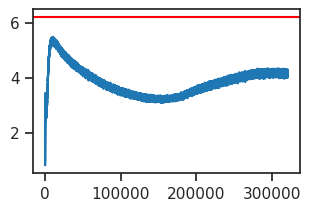

In [33]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

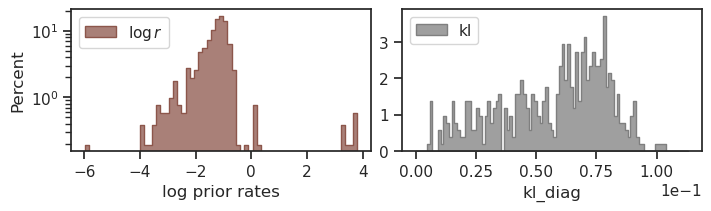

In [34]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(tonp(tr.model.log_rate.squeeze()), label=r'$\log r$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

add_legend(axes, loc='upper left')
axes[0].set(xlabel='log prior rates', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='linear')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

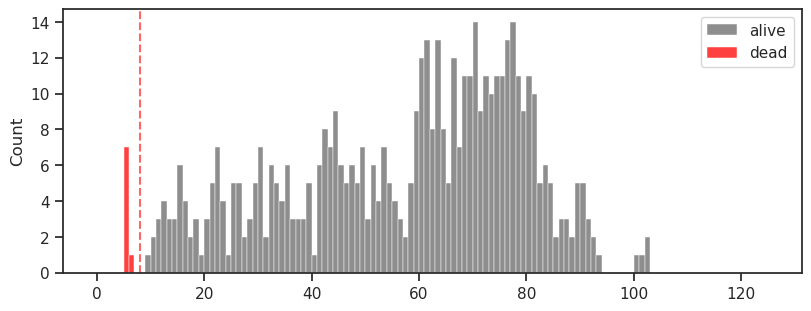

In [35]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 125, 126)
sns.histplot(loss['kl_diag'][~dead] * 1000, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 1000, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 1000, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.legend()
plt.show()

In [36]:
order = np.argsort(loss['kl_diag'])

w_dec = tonp(tr.model.fc_dec.weight)
norms = sp_lin.norm(w_dec, axis=0)

w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
norms = norms[order]
dead = dead[order]

norm99 = np.quantile(norms, 0.99)
norms_scaled = np.clip(norms / norm99, 0, 1)

In [37]:
tr.model.log_rate.squeeze()[order][dead]

tensor([-5.9669,  3.4290,  3.3480,  3.3325,  3.6297,  3.6894,  3.7004,  3.8062],
       device='cuda:0', grad_fn=<IndexBackward0>)

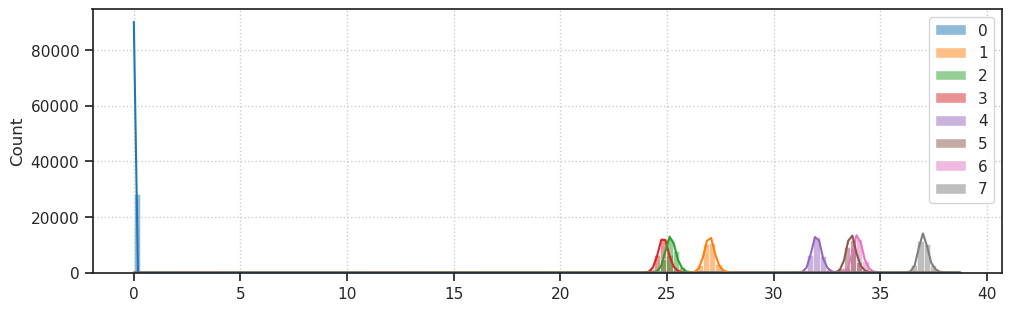

In [39]:
r_dr = etc['r*dr'][:, order]

fig, ax = create_figure(1, 1, (10, 3))
sns.histplot(r_dr[:, dead], kde=True)
plt.grid()
plt.show()

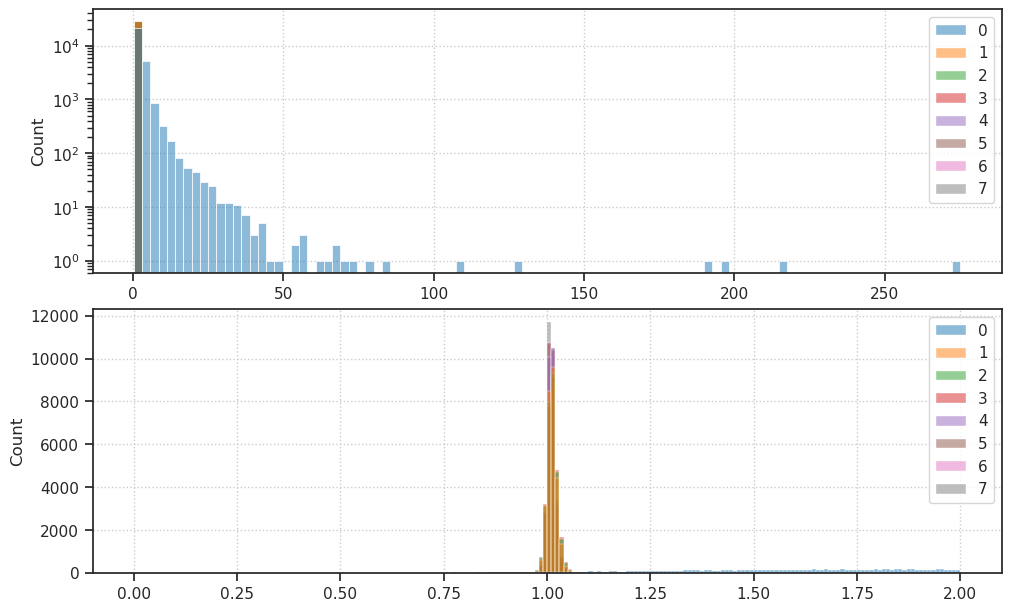

In [44]:
log_dr = etc['log_dr'][:, order]

fig, axes = create_figure(2, 1, (10, 6))
sns.histplot(np.exp(log_dr[:, dead]), bins=100, ax=axes[0])
axes[0].set_yscale('log')

sns.histplot(np.exp(log_dr[:, dead]), bins=np.linspace(0, 2, 201), ax=axes[1])

add_grid(axes)

plt.show()

In [48]:
dr = np.exp(log_dr)
dr_mu, dr_var = dr.mean(0), dr.var(0)

In [50]:
dr_var

array([1.65408802e+01, 1.40317177e-04, 1.59256815e-04, 1.67835489e-04,
       9.86891901e-05, 9.03981636e-05, 8.98593062e-05, 7.53528147e-05,
       2.49320126e+00, 6.01152277e+00, 2.68616605e+00, 4.23895359e+00,
       1.15237391e+00, 7.72028267e-01, 1.42898083e+00, 1.84344769e+00,
       4.18161392e+00, 5.83515882e-01, 7.25232959e-01, 2.91342306e+00,
       8.08773804e+00, 3.37512183e+00, 9.32457566e-01, 8.30155611e-01,
       1.44868338e+00, 6.56245172e-01, 9.07312930e-01, 6.50314140e+00,
       1.62937045e+00, 1.15556078e+01, 5.58778095e+00, 6.84335589e-01,
       3.18722134e+01, 6.61380708e-01, 4.24239588e+00, 7.47032940e-01,
       4.17406946e-01, 1.18516874e+00, 6.86362147e-01, 3.49910408e-01,
       5.65167546e-01, 8.38197231e-01, 4.48980808e-01, 6.20941043e-01,
       1.36558933e+01, 5.10924006e+00, 3.00326252e+00, 8.10509324e-01,
       1.40191615e+00, 1.47645366e+00, 8.98970068e-01, 1.09782124e+00,
       5.16780794e-01, 7.64121830e-01, 6.23778343e+00, 2.26723820e-01,
      

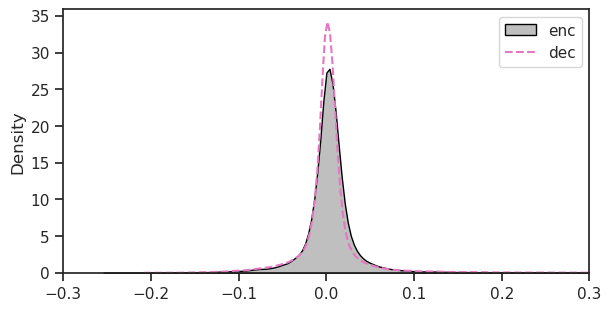

In [12]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

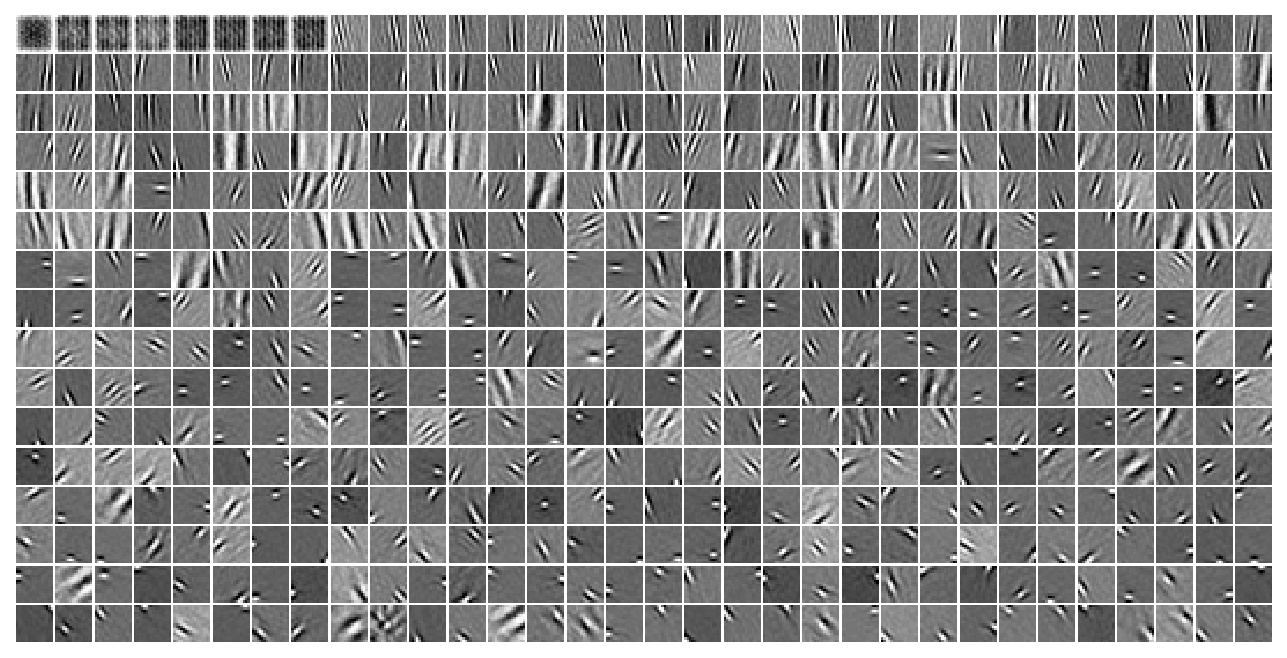

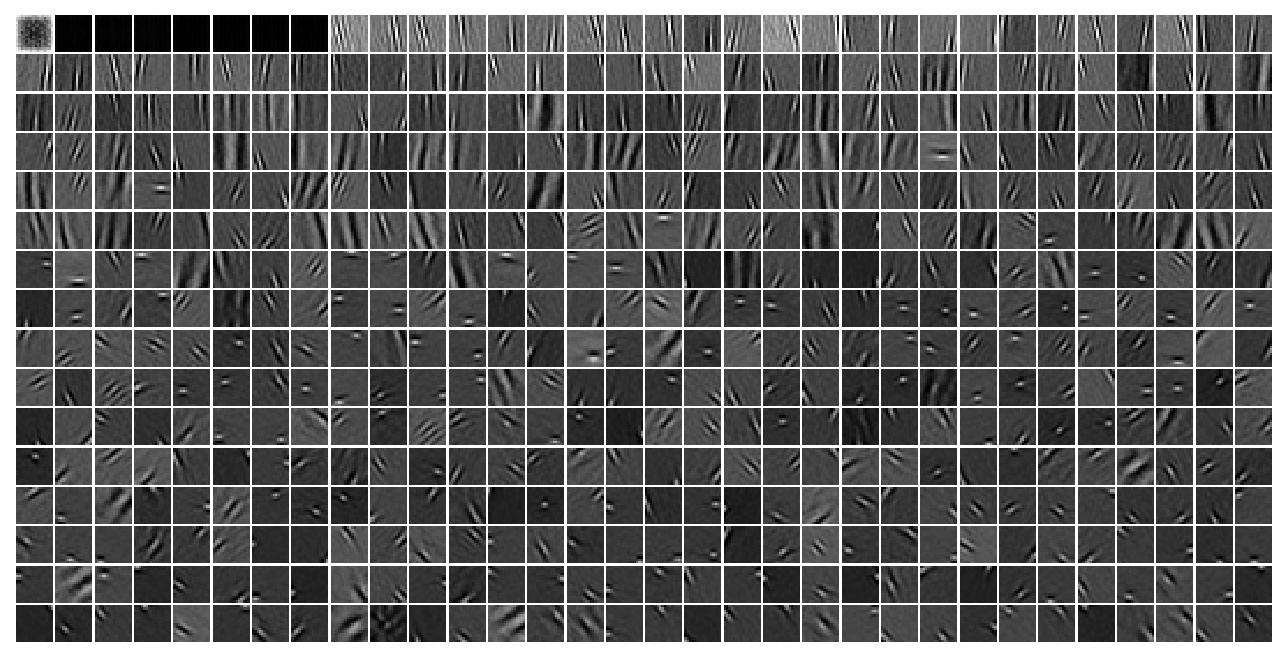

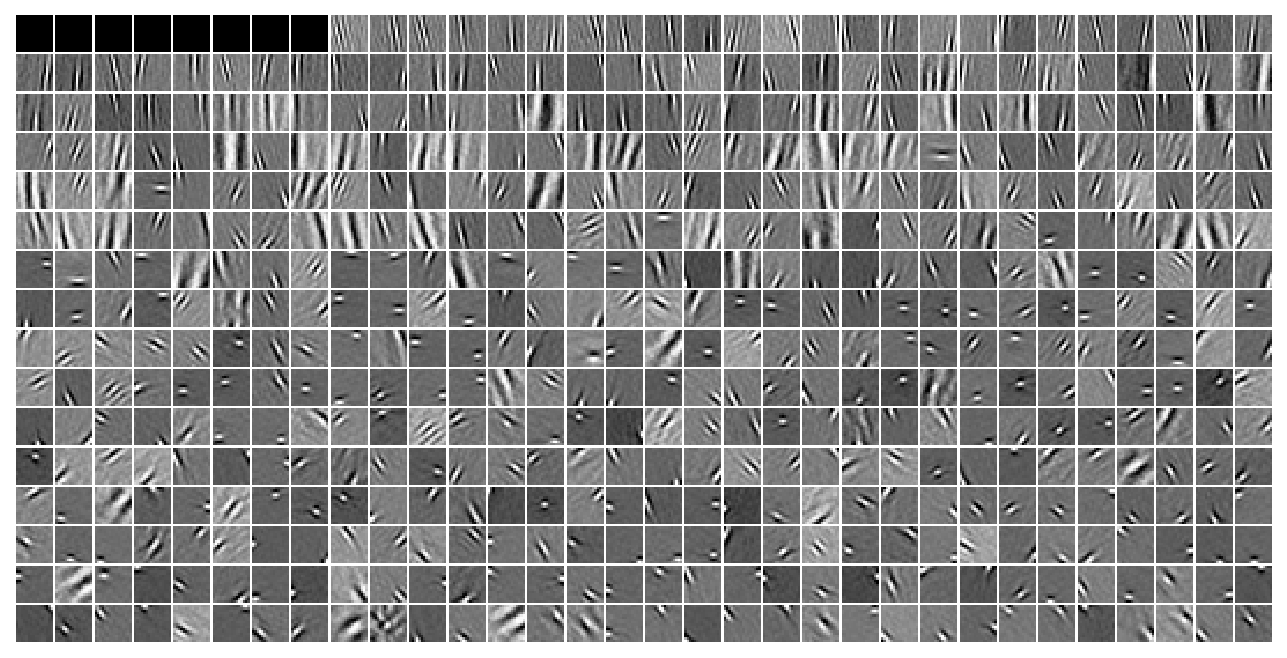

In [14]:
_ = plot_weights(w_dec, scaling=None)
_ = plot_weights(w_dec, scaling=norms_scaled)
_ = plot_weights(w_dec, scaling=(~dead).astype(float))

### Gaussian

In [15]:
tr = trainers['gaussian']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 122.74571, 'kl': 37.5456, 'kl_diag': 0.07292755, 'tot': 160.29132}

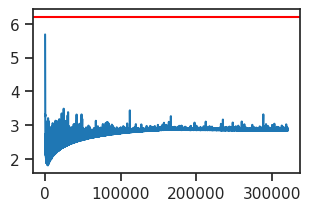

In [16]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

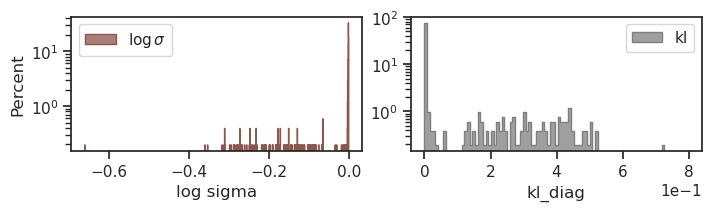

In [17]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(np.log(etc['scale'].mean(0)), label=r'$\log \sigma$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper right')
axes[0].set(xlabel='log sigma', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

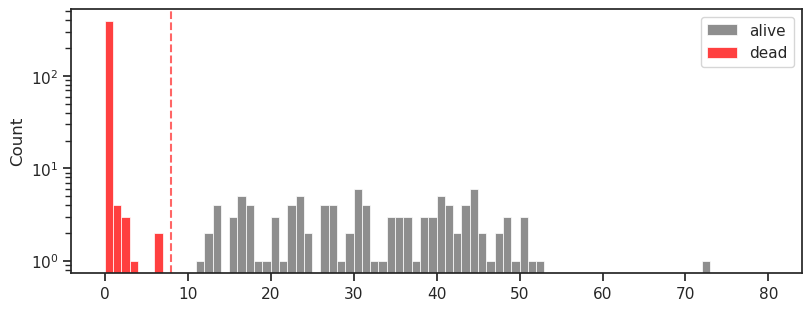

In [18]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 80, 81)
sns.histplot(loss['kl_diag'][~dead] * 100, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 100, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.legend()
plt.show()

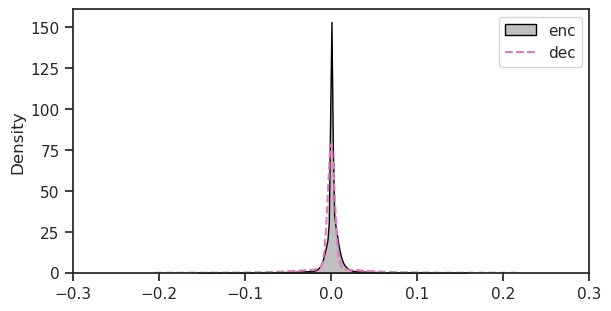

In [19]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

In [20]:
order = np.argsort(loss['kl_diag'])

w_dec = tonp(tr.model.fc_dec.weight)
norms = sp_lin.norm(w_dec, axis=0)

w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
norms = norms[order]
dead = dead[order]

norm99 = np.quantile(norms, 0.99)
norms_scaled = np.clip(norms / norm99, 0, 1)

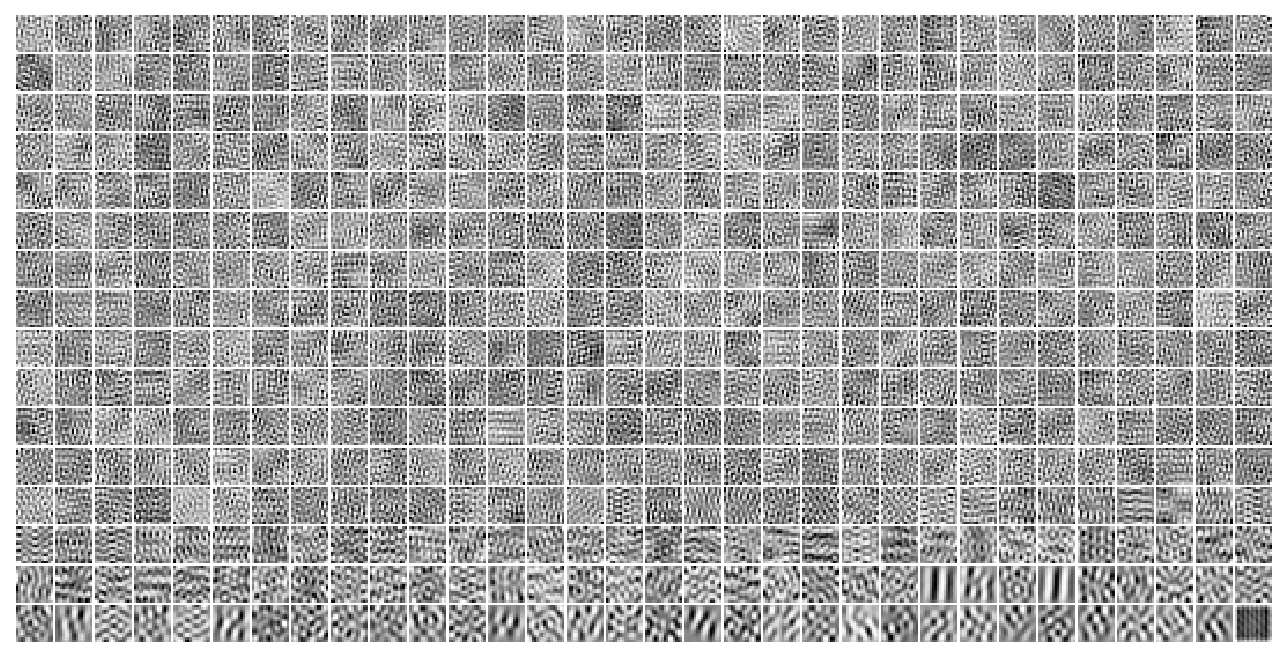

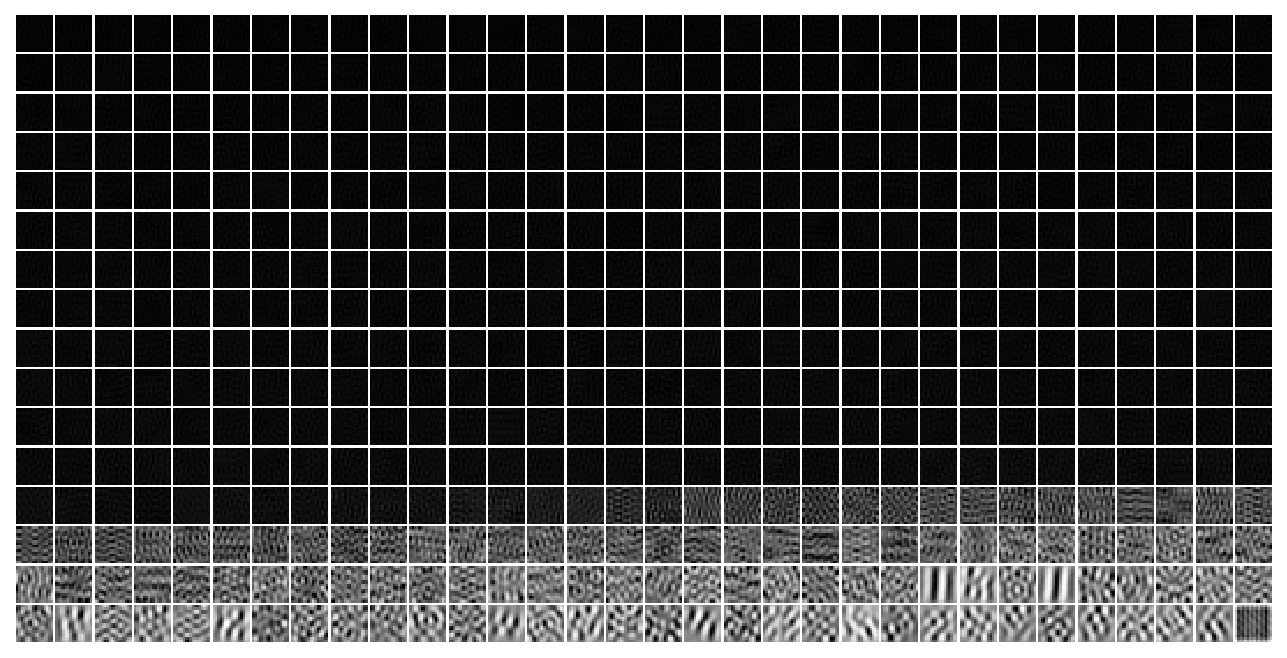

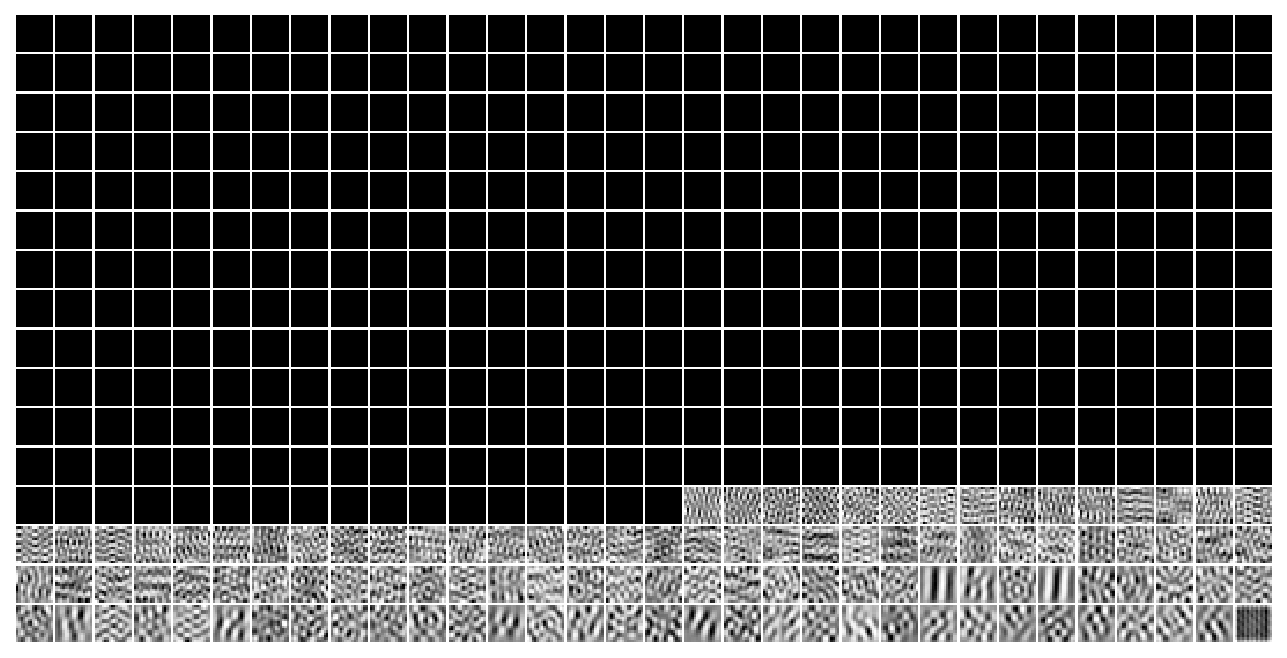

In [21]:
_ = plot_weights(w_dec, scaling=None)
_ = plot_weights(w_dec, scaling=norms_scaled)
_ = plot_weights(w_dec, scaling=(~dead).astype(float))

### Laplace

In [22]:
tr = trainers['laplace']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 126.97452, 'kl': 40.415375, 'kl_diag': 0.0784384, 'tot': 167.3899}

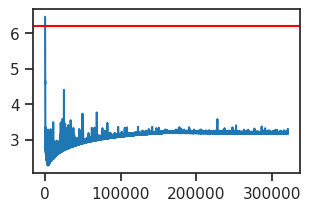

In [23]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

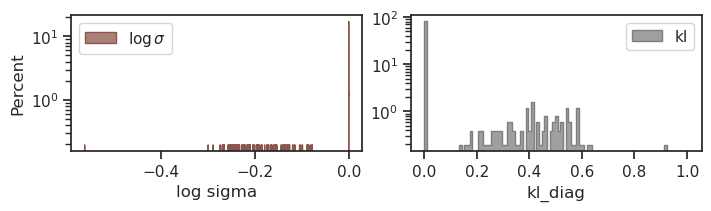

In [24]:
fig, axes = create_figure(1, 2, (7, 2.0), cnst=True)

kws = dict(stat='percent', element='step')
sns.histplot(np.log(etc['scale'].mean(0)), label=r'$\log \sigma$', color='C5', ax=axes[0], **kws)

bins = np.linspace(0, loss['kl_diag'].max() * 1.1, 100)
sns.histplot(loss['kl_diag'], bins=bins, ax=axes[1], label='kl', color='C7', **kws)

axes[0].legend(loc='upper left')
axes[1].legend(loc='upper right')
axes[0].set(xlabel='log sigma', yscale='log')
axes[1].set(xlabel='kl_diag', ylabel='', yscale='log')
axes[1].ticklabel_format(
    axis='x',
    style='sci',
    scilimits=(0, 0),
)
plt.show()

In [25]:
dead_thres = 8e-2
dead = loss['kl_diag'] < dead_thres
dead.sum()

416

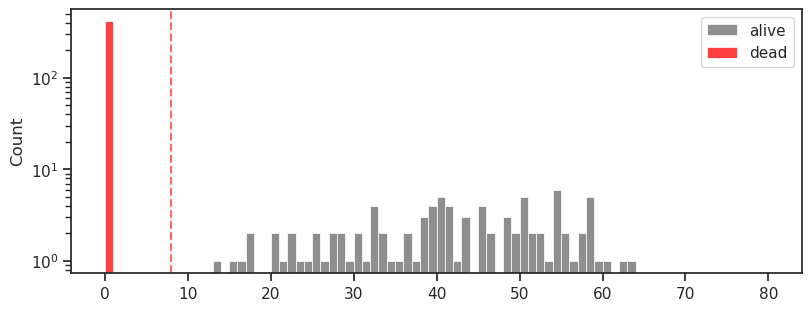

In [26]:
fig, ax = create_figure(1, 1, (8, 3))

bins = np.linspace(0, 80, 81)
sns.histplot(loss['kl_diag'][~dead] * 100, bins=bins, color='dimgrey', label='alive', ax=ax)
sns.histplot(loss['kl_diag'][dead] * 100, bins=bins, color='r', label='dead', ax=ax)
ax.axvline(dead_thres * 100, color='r', ls='--', alpha=0.6)
ax.locator_params(axis='x', nbins=11)
ax.set(yscale='log')
ax.legend()
plt.show()

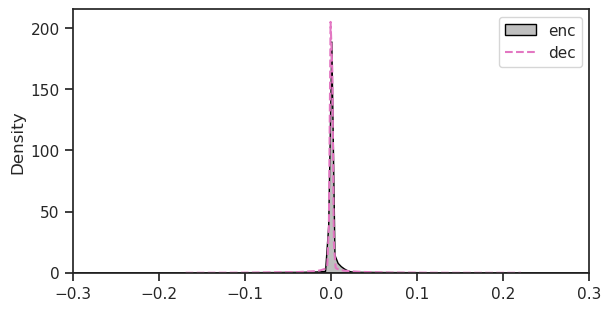

In [27]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-0.3, 0.3))
add_legend(ax)
plt.show()

In [28]:
order = np.argsort(loss['kl_diag'])

w_dec = tonp(tr.model.fc_dec.weight)
norms = sp_lin.norm(w_dec, axis=0)

w_dec = w_dec.T.reshape(-1, 16, 16)
w_dec = w_dec[order]
norms = norms[order]
dead = dead[order]

norm99 = np.quantile(norms, 0.99)
norms_scaled = np.clip(norms / norm99, 0, 1)

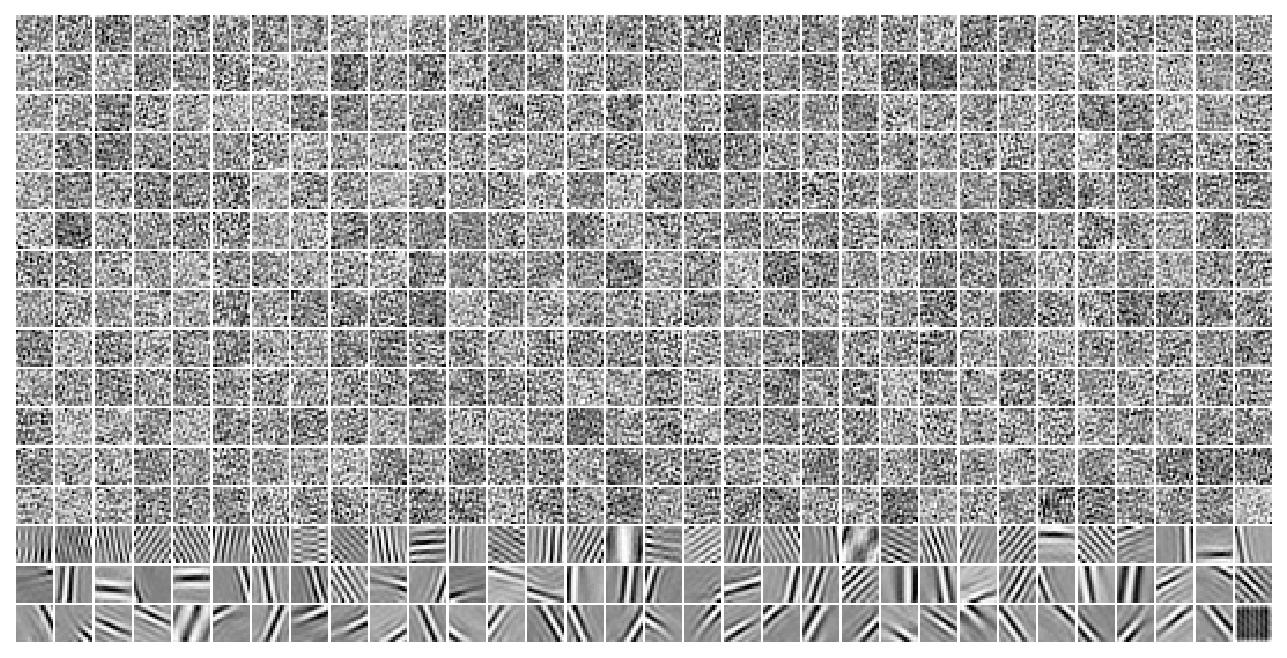

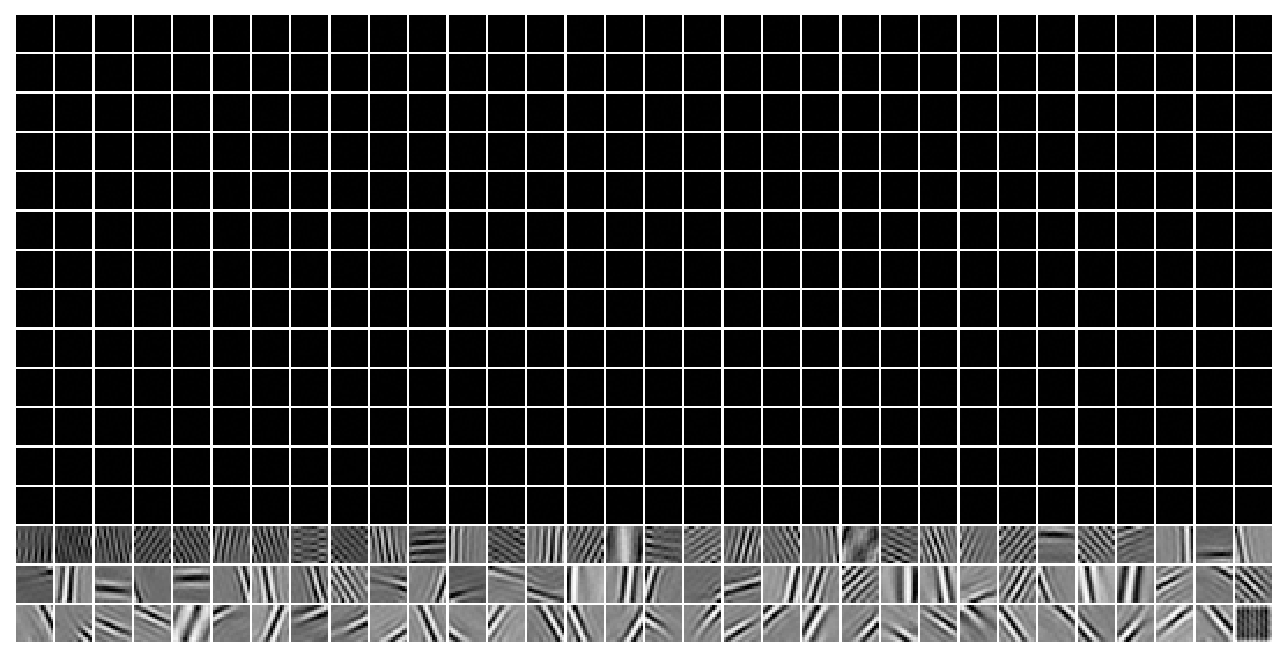

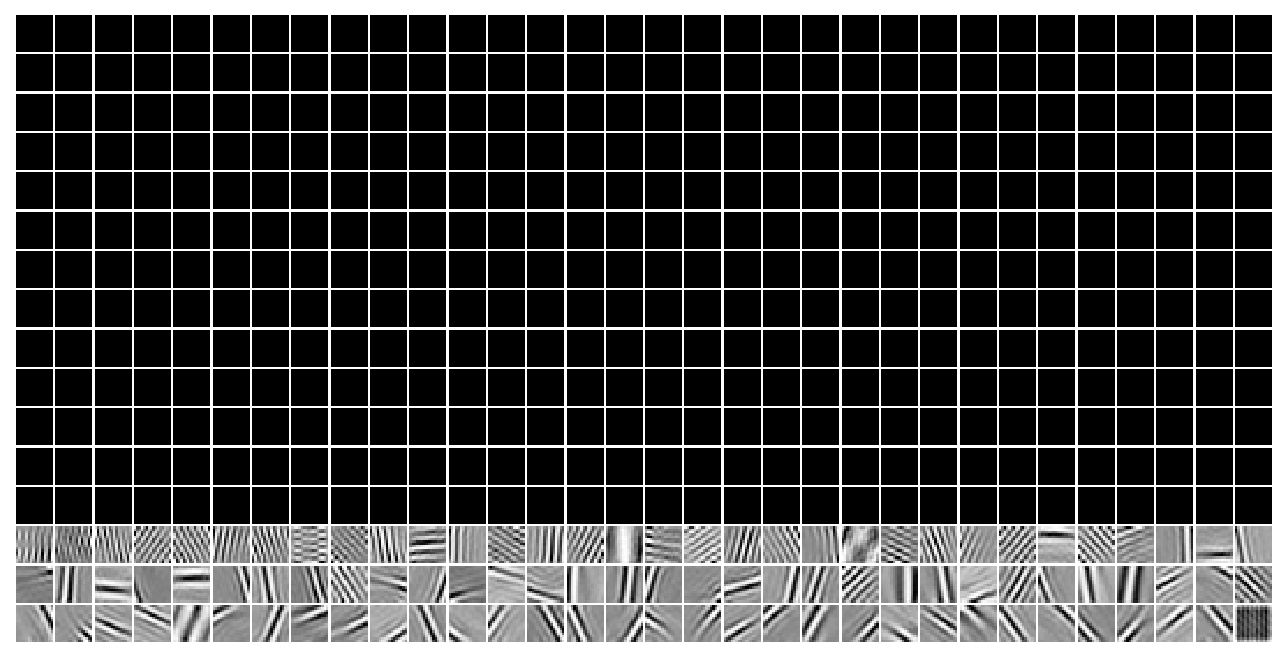

In [29]:
_ = plot_weights(w_dec, scaling=None)
_ = plot_weights(w_dec, scaling=norms_scaled)
_ = plot_weights(w_dec, scaling=(~dead).astype(float))

In [30]:
kl = loss['kl_diag'][order]

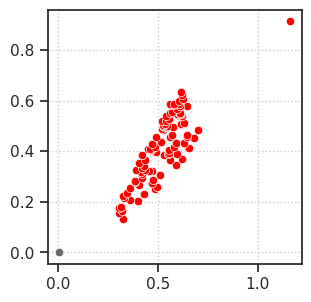

In [31]:
fig, ax = create_figure(1, 1, (3, 3))
sns.scatterplot(x=norms[~dead], y=kl[~dead], color='r', ax=ax)
sns.scatterplot(x=norms[dead], y=kl[dead], color='dimgrey', ax=ax)
ax_square(ax)
ax.grid()
plt.show()

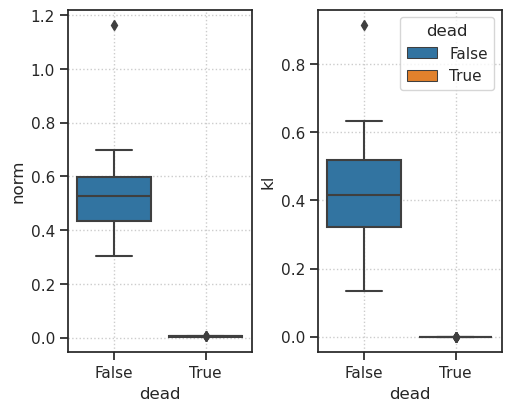

In [32]:
df = pd.DataFrame({'kl': kl, 'norm': norms, 'dead': dead})

fig, axes = create_figure(1, 2, (5, 4))
sns.boxplot(data=df, x='dead', y='norm', hue='dead', dodge=False, ax=axes[0])
sns.boxplot(data=df, x='dead', y='kl', hue='dead', dodge=False, ax=axes[1])
add_grid(axes)
move_legend(axes[0])
plt.show()

### Categorical

In [33]:
tr = trainers['categorical']
data, loss, etc, dead_thres, dead = detect_dead_neurons(tr)

loss_avg = {k: v.mean() for k, v in loss.items()}
loss_avg['tot'] = loss_avg['mse'] + loss_avg['kl']
print(loss_avg)

{'mse': 165.02698, 'kl': 5.4616976, 'kl_diag': 5.4436736, 'tot': 170.48868}

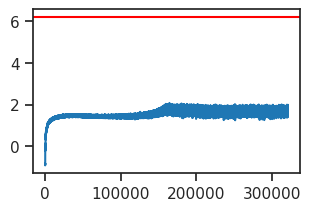

In [34]:
fig, ax = create_figure()
ax.plot(tr.stats['grad'].keys(), np.log(list(tr.stats['grad'].values())))
ax.axhline(np.log(tr.cfg.grad_clip), color='r')
plt.show()

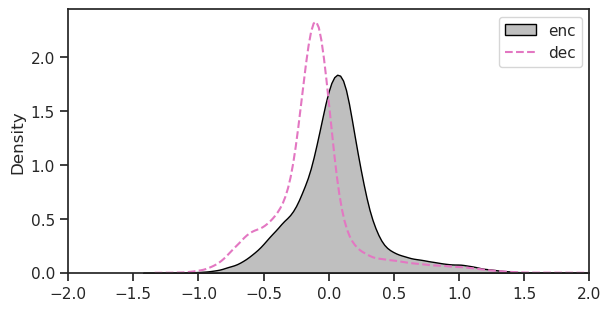

In [35]:
fig, ax= create_figure(figsize=(6, 3))
sns.kdeplot(tonp(tr.model.fc_enc.weight).ravel(), color='k', label='enc', fill=True, ax=ax)
sns.kdeplot(tonp(tr.model.fc_dec.weight).ravel(), color='C6', label='dec', ls='--', ax=ax)
ax.set(xlim=(-2.0, 2.0))
add_legend(ax)
plt.show()

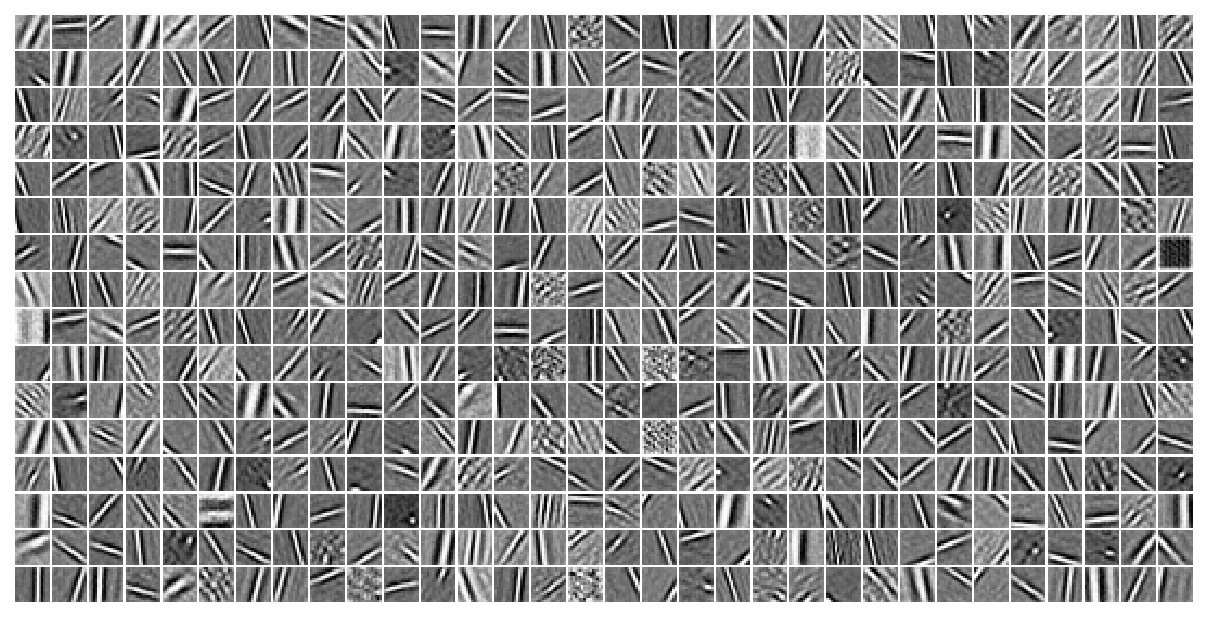

In [36]:
tr.model.show(dpi=150);